## ARIMA model

In [1]:
import pandas as pd

jj_df = pd.read_csv("data/jj.csv")

jj_df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


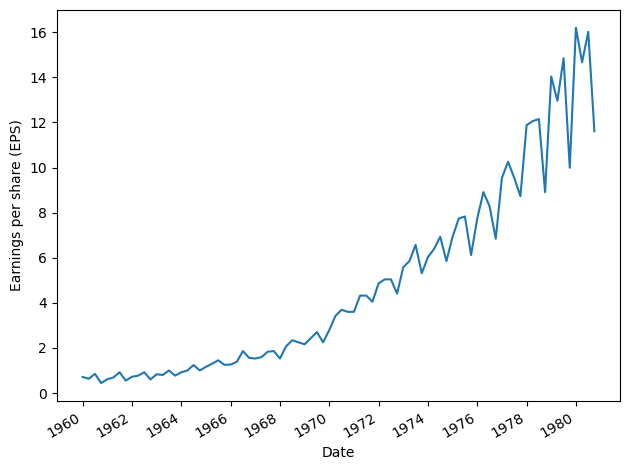

In [2]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots()

ax.plot(jj_df.date, jj_df.data)
ax.set_xlabel("Date")
ax.set_ylabel("Earnings per share (EPS)")

plt.xticks(np.arange(0, 81, 8),
           [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
fig.autofmt_xdate()
plt.tight_layout()

In [3]:
# check for stationarity

from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(jj_df["data"])
print(f"ADF stats: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")

ADF stats: 2.7420165734574744
p-value: 1.0


In [4]:
eps_diff = np.diff(jj_df["data"], n=1)

ADF_result = adfuller(eps_diff)
print(f"ADF stats: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")

ADF stats: -0.40740976363804615
p-value: 0.9088542416911305


In [6]:
eps_diff2 = np.diff(eps_diff, n=1)

ADF_result = adfuller(eps_diff2)
print(f"ADF stats: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")

ADF stats: -3.585162874793155
p-value: 0.006051099869603682


In [12]:
# Function to fit all unique ARIMA models
from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX


def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    results = []
    for order in tqdm(order_list):
        try:
            model = SARIMAX(endog=endog, order=(order[0], d, order[1]),
                            simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])
    
    results_df = pd.DataFrame(results)
    results_df.columns = ["(p, q)", "AIC"]

    results_df = results_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

    return results_df

In [8]:
from itertools import product

ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 2

order_list = list(product(ps, qs))

In [13]:
train = jj_df.data[:-4]

result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

/home/alexa/miniconda3/envs/timeseriesML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/alexa/miniconda3/envs/timeseriesML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/alexa/miniconda3/envs/timeseriesML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/alexa/miniconda3/envs/timeseriesML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('No

,"(p, q)",AIC
0,"(3, 3)",115.269458
1,"(3, 1)",115.624980
2,"(3, 2)",115.672007
3,"(3, 0)",154.430678
4,"(0, 3)",194.654716
5,"(0, 2)",209.274506
6,"(2, 3)",220.666829
7,"(1, 3)",228.267773
8,"(1, 2)",228.935764
9,"(2, 2)",229.974686


/home/alexa/miniconda3/envs/timeseriesML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/alexa/miniconda3/envs/timeseriesML/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


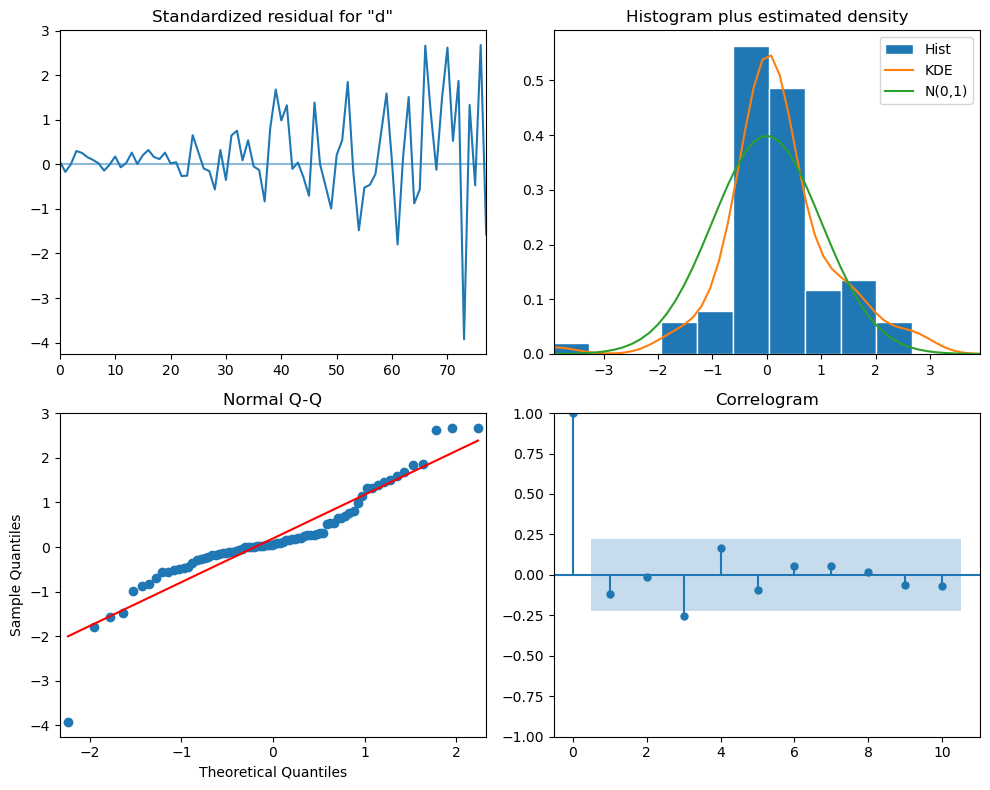

In [14]:
model = SARIMAX(train, order=(3, 2, 3), simple_differencing=False)
model_fit = model.fit(disp=False)

model_fit.plot_diagnostics(figsize=(10, 8))

plt.tight_layout()

In [15]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = model_fit.resid

ljungbox_df = acorr_ljungbox(residuals, np.arange(1, 11, 1))

ljungbox_df

,lb_stat,lb_pvalue
1,1.732420,0.188102
2,1.736635,0.419657
3,7.304374,0.062804
4,9.294758,0.054140
5,9.921809,0.077481
6,10.162270,0.117983
7,10.408218,0.166596
8,10.439297,0.235536
9,10.776536,0.291338
10,11.209887,0.341401


In [16]:
test = jj_df.iloc[-4:]
test["naive_seasonal"] = jj_df["data"].iloc[76:80].values


/tmp/ipykernel_19781/2281168171.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["naive_seasonal"] = jj_df["data"].iloc[76:80].values


In [17]:
ARIMA_pred = model_fit.get_prediction(80, 83).predicted_mean
test["ARIMA_pred"] = ARIMA_pred

/tmp/ipykernel_19781/1615226436.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["ARIMA_pred"] = ARIMA_pred


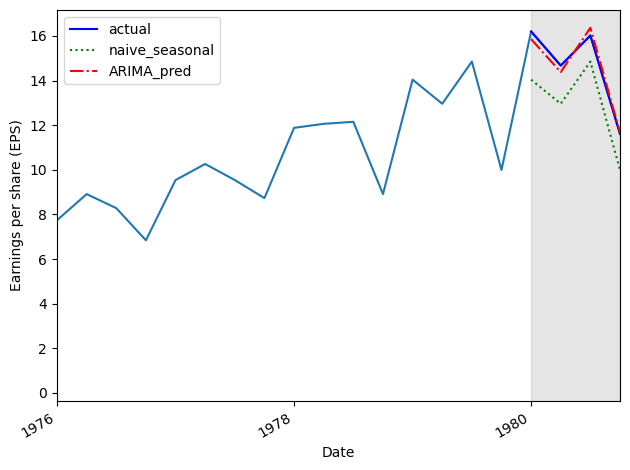

In [32]:
fig, ax = plt.subplots()

ax.plot(jj_df.date, jj_df.data)
ax.plot(test["data"], "b-", label="actual")
ax.plot(test["naive_seasonal"], "g:", label="naive_seasonal")
ax.plot(test["ARIMA_pred"], "r-.", label="ARIMA_pred")
ax.set_xlabel("Date")
ax.set_ylabel("Earnings per share (EPS)")
ax.legend(loc=2)

ax.axvspan(80, 83, color="#808080", alpha=0.2)

ax.set_xlim(70, 83)


plt.xticks(np.arange(64, 81, 8),
           [1976, 1978, 1980])
fig.autofmt_xdate()
plt.tight_layout()

In [33]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [34]:
mape_naive_seasonal = mape(test["data"], test["naive_seasonal"])
mape_ARIMA = mape(test["data"], test["ARIMA_pred"])


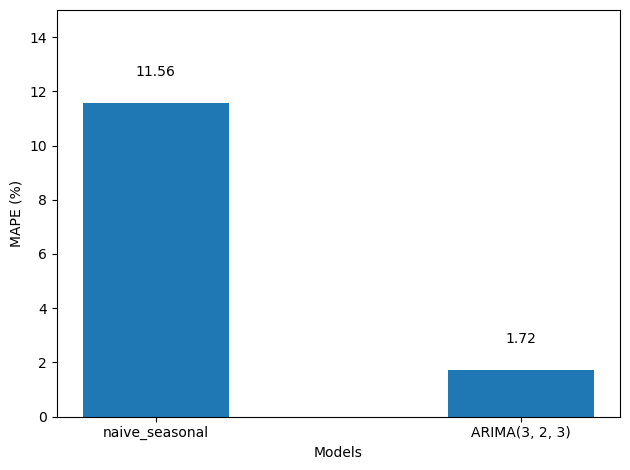

In [35]:
fig, ax = plt.subplots()

x = ["naive_seasonal", "ARIMA(3, 2, 3)"]
y = [mape_naive_seasonal, mape_ARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel("Models")
ax.set_ylabel("MAPE (%)")
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value, 2)), ha="center")

plt.tight_layout()